In [17]:
%%capture --no-stderr
%pip install --quiet -U numpy opencv-python rasterio matplotlib

In [18]:
import cv2
import numpy as np
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt

In [18]:
def dark_object_subtraction(image_path, percentile=0.1):

    # Read the image in BGR format
       # Load the image
    image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)

    if image is None:
        raise ValueError(f"Could not read image from {image_path}")

    # Assume image is a NumPy array (BGR or multispectral)
    dark_pixel = np.percentile(image, percentile, axis=(0, 1))
    corrected = np.clip(image - dark_pixel, 0, 255).astype(np.uint8)
    return corrected

In [20]:
# Example usage
corrected_image = dark_object_subtraction("testfiles/DJI_0025-h60.jpeg")
cv2.imwrite("corrected_image.jpeg", corrected_image)

True

Complex DOS and RC

In [6]:
def rigorous_radiometric_correction(image_path, gain, offset, sunelev, edist, Esun, blackadjust=0.01, percentile=0.1):
    """
    Perform rigorous radiometric correction for a multispectral drone image.
    
    Parameters:
      image_path (str): Path to the multispectral image (e.g., from DJI Mavic 3M)
      gain (array-like): Sensor gain for each band (list or numpy array)
      offset (array-like): Sensor offset for each band
      sunelev (float): Sun elevation in degrees
      edist (float): Earth–Sun distance (in astronomical units)
      Esun (array-like): Exo-atmospheric solar irradiance for each band
      blackadjust (float): Adjustment factor (default 0.01) to account for non‑absolute black
      percentile (float): Percentile value (in percent) for dark object estimation (e.g., 0.1 for 0.1th percentile)
      
    Returns:
      np.ndarray: Corrected reflectance image (floating point, typically with values in [0, 1])
    """
    # Load the image (assumed to be multispectral; shape: H x W x bands)
    image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
    if image is None:
        raise ValueError(f"Could not read image from {image_path}")
    
    # Convert image to float32 for calculations
    image = image.astype(np.float32)
    
    # Convert digital numbers (DN) to radiance for each band:
    # Radiance = gain * DN + offset
    h, w, n_bands = image.shape
    radiance = np.empty_like(image)
    for i in range(n_bands):
        radiance[:, :, i] = gain[i] * image[:, :, i] + offset[i]
    
    # Convert radiance to reflectance.
    # Reflectance = (pi * radiance) / (Esun * cos(sun_zenith)) with sun zenith = (90 - sunelev)
    sun_zenith = 90 - sunelev
    cos_sun_zenith = np.cos(np.deg2rad(sun_zenith))
    # Ensure Esun is an array (per band) and apply Earth-Sun distance correction
    Esun = np.array(Esun)
    reflectance = (np.pi * radiance) / (Esun * cos_sun_zenith)
    reflectance = reflectance / (edist ** 2)
    
    # Estimate the dark object value per band on the reflectance image.
    # Using the specified percentile over the spatial dimensions.
    dark_obj = np.percentile(reflectance, percentile, axis=(0, 1))  # dark_obj is per band
    
    # Apply the black adjustment (reduce dark object value by the given fraction)
    dark_obj_adj = dark_obj * (1 - blackadjust)
    
    # Subtract the adjusted dark object value from each band and clip to a valid reflectance range (e.g., [0, 1])
    corrected = np.empty_like(reflectance)
    for i in range(reflectance.shape[2]):
        corrected[:, :, i] = np.clip(reflectance[:, :, i] - dark_obj_adj[i], 0, 1)
    
    return corrected


In [15]:
def rigorous_radiometric_correction_rasterio(image_path, gain, offset, sunelev, edist, Esun, blackadjust=0.01, percentile=0.1):
    """
    Perform rigorous radiometric correction for a multispectral image using rasterio.
    
    Parameters:
      image_path (str): Path to the multispectral image
      gain (array-like): Sensor gain for each band
      offset (array-like): Sensor offset for each band
      sunelev (float): Sun elevation in degrees
      edist (float): Earth–Sun distance (in astronomical units)
      Esun (array-like): Exo-atmospheric solar irradiance for each band
      blackadjust (float): Adjustment factor for dark object subtraction
      percentile (float): Percentile for dark object estimation
      
    Returns:
      np.ndarray: Corrected reflectance image
    """
    with rasterio.open(image_path) as src:
        image = src.read().astype(np.float32)  # Shape: (bands, H, W)
    
    if image is None:
        raise ValueError(f"Could not read image from {image_path}")
    
    # Get number of bands
    n_bands, h, w = image.shape
    
    # Convert digital numbers (DN) to radiance: Radiance = gain * DN + offset
    radiance = np.empty_like(image)
    for i in range(n_bands):
        radiance[i, :, :] = gain[i] * image[i, :, :] + offset[i]
    
    # Compute sun zenith angle
    sun_zenith = 90 - sunelev
    cos_sun_zenith = np.cos(np.deg2rad(sun_zenith))
    Esun = np.array(Esun)
    
    # Convert radiance to reflectance
    reflectance = (np.pi * radiance) / (Esun[:, None, None] * cos_sun_zenith)
    reflectance /= edist ** 2
    
    # Estimate dark object value per band
    dark_obj = np.percentile(reflectance, percentile, axis=(1, 2))
    dark_obj_adj = dark_obj * (1 - blackadjust)
    
    # Apply dark object subtraction and clip
    corrected = np.clip(reflectance - dark_obj_adj[:, None, None], 0, 1)
    
    return corrected


In [23]:
# Example usage:
if __name__ == "__main__":
    image_path = "testfiles/20180627_seq_50m_NC.tif"
    gain = [0.1, 0.11, 0.09, 0.1, 0.12]  # 5-band sensor
    offset = [1, 1, 1, 1, 1]
    sunelev = 60.0
    edist = 1.0
    Esun = [1800, 1700, 1600, 1500, 1400]
    
    corrected_reflectance = rigorous_radiometric_correction_rasterio(
        image_path, gain, offset, sunelev, edist, Esun, blackadjust=0.01, percentile=0.1
    )
    
    # Save corrected reflectance as a new GeoTIFF
    with rasterio.open(image_path) as src:
        profile = src.profile.copy()
        profile.update(dtype=rasterio.float32, count=corrected_reflectance.shape[0])
    
    output_path = "corrected_reflectance.tif"
    with rasterio.open(output_path, 'w', **profile) as dst:
        dst.write(corrected_reflectance.astype(np.float32))
    
    # Visualization (convert to 8-bit)
    vis = (corrected_reflectance * 255).astype(np.uint8)
    vis_output_path = "corrected_reflectance_vis.tif"
    with rasterio.open(vis_output_path, 'w', **profile) as dst:
        dst.write(vis)

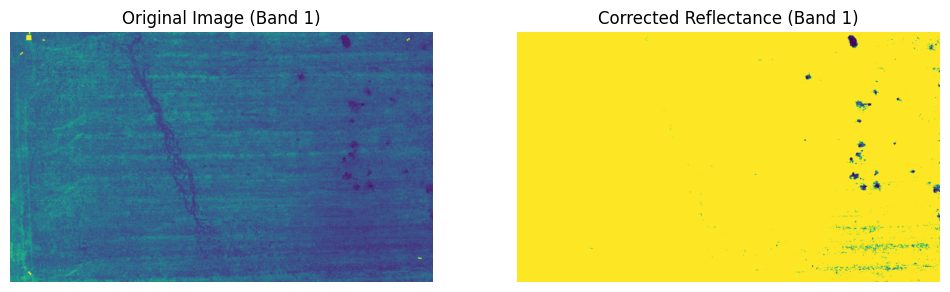

In [28]:
def plot_images(original_path, corrected_array, band=0):
    """
    Plot the original and corrected images for a given band.

    Parameters:
      original_path (str): Path to the original image.
      corrected_array (np.ndarray): Radiometrically corrected reflectance array (bands, height, width).
      band (int): Band index to visualize (0-based indexing).

    """
    # Load original image
    with rasterio.open(original_path) as src:
        original = src.read(band + 1)  # Raster bands are 1-indexed

    # Normalize original image
    min_o, max_o = np.min(original), np.max(original)
    original_norm = (original - min_o) / (max_o - min_o) if max_o > min_o else original

    # Normalize corrected image (bands, height, width)
    corrected_band = corrected_array[band, :, :]
    min_c, max_c = np.min(corrected_band), np.max(corrected_band)
    corrected_norm = (corrected_band - min_c) / (max_c - min_c) if max_c > min_c else corrected_band

    # Plot both images
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    
    ax[0].imshow(original_norm, cmap='viridis')
    ax[0].set_title(f"Original Image (Band {band + 1})")
    ax[0].axis("off")

    ax[1].imshow(corrected_norm, cmap='viridis')
    ax[1].set_title(f"Corrected Reflectance (Band {band + 1})")
    ax[1].axis("off")

    plt.show()

# Call the function after running your correction process
plot_images("testfiles/20180627_seq_50m_NC.tif", corrected_reflectance, band=0)

In [26]:
print("Original shape:", rasterio.open(image_path).read().shape)  # (bands, height, width)
print("Corrected shape:", corrected_reflectance.shape)  # Should be (height, width, bands)


Original shape: (5, 1078, 1820)
Corrected shape: (5, 1078, 1820)


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Implementing Geometric correction